In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
DIRECTORY_PATH = os.getcwd() + "/panaroma_generation/"
IMAGE_CNT = 8

[[ 9.  3.  4. ...  0.  0.  2.]
 [27.  9.  3. ...  0.  0.  0.]
 [13.  0.  0. ...  5.  2.  2.]
 ...
 [11.  8.  1. ...  2.  0.  0.]
 [68.  8.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  3.  7.]]


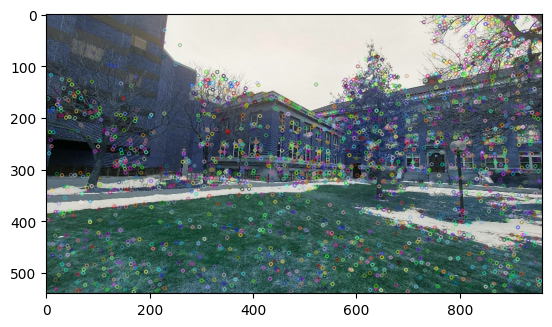

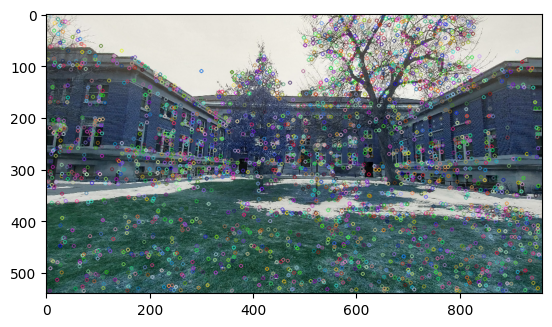

In [5]:
img1 = cv2.imread(DIRECTORY_PATH + "1.jpg")
img2 = cv2.imread(DIRECTORY_PATH + "2.jpg")

# Detect the keypoints using SIFT
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

print(descriptors1)

# Draw keypoints on the images
img1_with_kp = cv2.drawKeypoints(img1, keypoints1, img1)
img2_with_kp = cv2.drawKeypoints(img2, keypoints2, img2)

# Display the images with keypoints
plt.imshow(img1_with_kp)
plt.show()

plt.imshow(img2_with_kp)
plt.show()

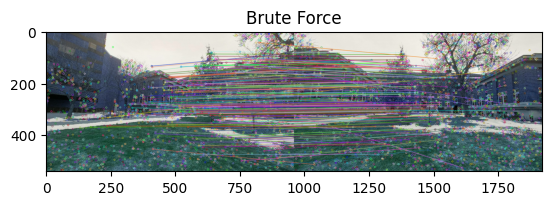

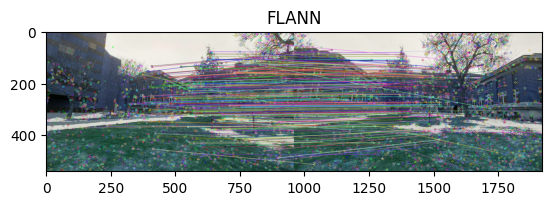

In [76]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2 ,k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1, keypoints1, img2, keypoints2, good, None, flags=2)

plt.imshow(img3)
plt.title("Brute Force")
plt.show()

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1, keypoints1, img2, keypoints2, good, None, flags=2)

plt.imshow(img3)
plt.title("FLANN")
plt.show()

In [77]:
pts1 = np.float32([keypoints1[m[0].queryIdx].pt for m in good]).reshape(-1,1,2)
pts2 = np.float32([keypoints2[m[0].trainIdx].pt for m in good]).reshape(-1,1,2)

# Compute Homography
H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC,5.0)

print("Homography Matrix: \n", H)

Homography Matrix: 
 [[-5.34171260e+01  1.33010093e+00  1.92886325e+04]
 [-1.62199190e+01 -3.29071626e+01  1.00755356e+04]
 [-5.55509115e-02 -1.22547678e-03  1.00000000e+00]]


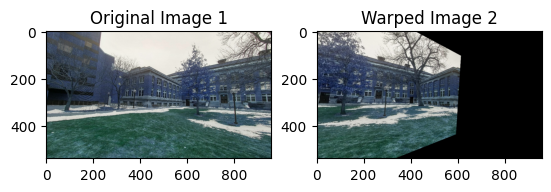

In [78]:
# Loading the images again to avoid the changes made in the previous steps
img1 = cv2.imread(DIRECTORY_PATH + "1.jpg")
img2 = cv2.imread(DIRECTORY_PATH + "2.jpg")

# Use homography to warp image
height, width, _ = img1.shape
img2_warped = cv2.warpPerspective(img2, H, (width, height))

# Display the warped and original images side by side
plt.subplot(1,2,1),plt.imshow(img1),plt.title('Original Image 1')
plt.subplot(1,2,2),plt.imshow(img2_warped),plt.title('Warped Image 2')
plt.show()

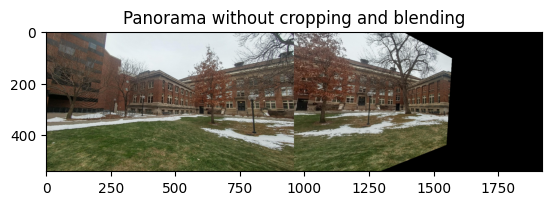

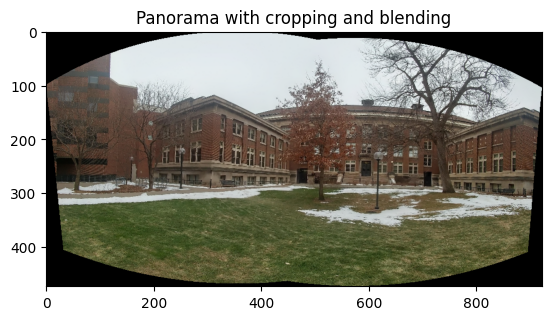

In [79]:
# Combine the images
panorama = np.zeros((height, width*2, 3), dtype=np.uint8)
panorama[0:img1.shape[0], 0:img1.shape[1]] = img1
panorama[0:img2_warped.shape[0], img1.shape[1]:img1.shape[1]+img2_warped.shape[1]] = img2_warped

# Display the panorama withot cropping and blending
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.title('Panorama without cropping and blending')
plt.show()

# Create a panorama with cropping and blending using OpenCV's Stitcher class
stitcher = cv2.Stitcher.create()
status, panorama_crop = stitcher.stitch([img1, img2])

# Display the panorama with cropping and blending
plt.imshow(cv2.cvtColor(panorama_crop, cv2.COLOR_BGR2RGB))
plt.title('Panorama with cropping and blending')
plt.show()

Error during stitching with image d:\Desktop\IIIT D Course Material\6th sem\CV\CV - Assignments\Ass3 - Epipolar Geometry and Panorama generation/panaroma_generation/6.jpg , status code = 1
Error during stitching with image d:\Desktop\IIIT D Course Material\6th sem\CV\CV - Assignments\Ass3 - Epipolar Geometry and Panorama generation/panaroma_generation/7.jpg , status code = 1
Error during stitching with image d:\Desktop\IIIT D Course Material\6th sem\CV\CV - Assignments\Ass3 - Epipolar Geometry and Panorama generation/panaroma_generation/8.jpg , status code = 1


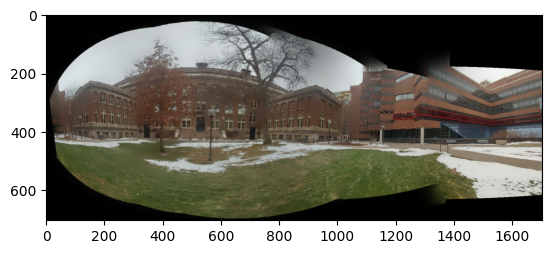

In [80]:
image_files = [DIRECTORY_PATH + str(i) + ".jpg" for i in range(1, IMAGE_CNT+1)]

# Load the first image
panorama = cv2.imread(image_files[0])

# Create a Stitcher instance
stitcher = cv2.Stitcher.create()

# Iterate over the rest of the image files
for image_file in image_files[1:]:
    # Load the next image
    img = cv2.imread(image_file)

    # Stitch the image to the panorama
    status, panorama_temp = stitcher.stitch([panorama, img])

    # Check if stitching was successful
    if status == cv2.Stitcher_OK:
        panorama = panorama_temp
    else:
        print('Error during stitching with image', image_file, ', status code =', status)
        continue

# Display the final panorama
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.show()